# Comparison of algorithms

A notebook to producer a comparison of algorithms plot for publication to compare recall for different algorithms, forming a basis for choice of algorithm.

In [1]:
import os
import sys
import pathlib
import functools
import itertools
import datetime
import random

In [2]:
import pandas
import numpy

In [3]:
import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [4]:
font = {'family' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.pyplot.style.use('ggplot')

In [5]:
import ipywidgets
import time

In [6]:
import sklearn
import sklearn.model_selection
import sklearn.neural_network
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble

In [7]:
import xgboost

In [8]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [9]:
import xbt.dataset
from xbt.dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [10]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'
print(environment)

local


In [11]:
try:
    root_data_dir = os.environ['XBT_ROOT_DIR']
except KeyError:
    root_data_dir = '/data/users/shaddad/xbt-data/',
    
year_range = (1966,2015)
print(root_data_dir)
print(year_range)

/Users/stephen.haddad/data/xbt-data/
(1966, 2015)


In [12]:
plots_dir = pathlib.Path(root_data_dir) / 'plots'
if not plots_dir.is_dir():
    plots_dir.mkdir()

In [13]:
metrics_avg = 'weighted'
cv_metric_names = [f'recall_{metrics_avg}', f'precision_{metrics_avg}', f'f1_{metrics_avg}']
input_feature_names = ['country','max_depth', 'year', 'lat', 'lon']
target_feature_name = 'instrument'

In [14]:
splitter_features = ['year', 'instrument']
test_feature = 'cruise_number'
ensemble_test_fraction = 0.1
num_test_splits = 3
test_fraction = 1.0 / num_test_splits
num_train_splits = 3
train_fraction = 1.0 - (1.0 / num_train_splits)
test_fold_name = 'test_fold'

In [15]:
input_dir_name = 'dask_clean'
exp_out_dir_name = 'experiment_outputs'

In [16]:
experiment_name = 'nb_single_decisionTree_country'
classifier_name = 'decision_tree'
suffix='countryAndLatLon'

In [86]:
classifier_opts = {'mlp': {
                       'opts' : { 'hidden_layer_sizes': [10, 10],
                             'alpha': 1e-4,
                             'max_iter': 1000},
                       'class': sklearn.neural_network.MLPClassifier,
                       'name': 'Neural network',
                   },
                   'decision_tree' :
                   {
                       'opts': {'max_depth': 20,
                                'min_samples_leaf': 1,
                                'criterion': 'gini'
                              },
                       'class': sklearn.tree.DecisionTreeClassifier,
                       'name': 'Decision Tree',
                   },
                   'random_forest': {
                       'opts':  {'max_depth': 20,
                                'min_samples_leaf': 1,
                                'criterion': 'gini'
                                },
                       'class': sklearn.ensemble.RandomForestClassifier,
                       'name': 'Random Forest',
                   },
                   'xbgoost': {
                       'opts':  {'objective':'binary:logistic', 
                                 'n_estimators':10},
                       'class': xgboost.XGBClassifier,
                       'name': 'eXtreme Gradient-Boosted Trees',
                   },
                   'logreg': {
                       'opts': {'tol': 1e-3, 
                               'C': 0.5,
                               'max_iter': 500,
                              },
                       'class': sklearn.linear_model.LogisticRegression,
                       'name': 'Logistic Regression',
                   },                   
                   
                  }



In [18]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [19]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /Users/stephen.haddad/data/xbt-data/experiment_outputs/nb_single_decisionTree_country


In [20]:
output_fname_template = 'xbt_output_{exp_name}_{subset}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [21]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 5.67 s, sys: 1.2 s, total: 6.86 s
Wall time: 6.97 s


## Data preparation

We are only testing on the labelled data, to be able to evluate performance. The XbtDataset class has filtered out some bad data including profiles with maximum depths less that 0.0 or greater than 2000.0. There were also some profiles with bad date entries, which have been excluded for now.

In [22]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 240 ms, sys: 84 ms, total: 324 ms
Wall time: 321 ms


In [23]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [24]:
_ = xbt_labelled.filter_features(['instrument','model','manufacturer']).encode_target(return_data = False)

In [25]:
%%time
test_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)
test_var_name = 'test'
test_part_name = 'test_part'
test_whole_name = 'test_whole'
test_indices = list(itertools.chain.from_iterable([list(xbt_labelled.filter_obs({target_feature_name: selected_instrument}).xbt_df.sample(frac=0.1).index) 
for selected_instrument in xbt_labelled['instrument'].unique()]))

CPU times: user 1.15 s, sys: 53.5 ms, total: 1.2 s
Wall time: 1.2 s


In [26]:
# label test data based on whole cruises set aside
xbt_labelled.xbt_df[test_var_name] = xbt_labelled.xbt_df['cruise_number'].isin(test_cruise_numbers)
xbt_labelled.xbt_df[test_whole_name] = xbt_labelled.xbt_df['cruise_number'].isin(test_cruise_numbers)

In [27]:
# label test data where part of the cruise is in the train/validation sets
xbt_labelled.xbt_df.loc[test_indices, test_var_name] = True
xbt_labelled.xbt_df[test_part_name] = False
xbt_labelled.xbt_df.loc[test_indices, test_part_name] = True


In [28]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [29]:
imeta_feature_name = f'{target_feature_name}_imeta'

In [30]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 
xbt_labelled.xbt_df[imeta_feature_name] = imeta_instrument
xbt_labelled._target_encoders[imeta_feature_name] = xbt_labelled._target_encoders[target_feature_name]
xbt_labelled._feature_encoders[imeta_feature_name] = xbt_labelled._feature_encoders[target_feature_name]

In [31]:
%%time
xbt_test = xbt_labelled.filter_obs({test_var_name: True})
xbt_working = xbt_labelled.filter_obs({test_var_name: False})

CPU times: user 112 ms, sys: 26 ms, total: 138 ms
Wall time: 137 ms


get separate sets of 2 types of validation data.
* data from cruises where the whole cruise is in the validation data 
* data where some of the profiles are in the training data

In [32]:
xbt_test_whole = xbt_labelled.filter_obs({test_whole_name: True})
xbt_test_part = xbt_labelled.filter_obs({test_part_name: True})

In [33]:
X_working_all = xbt_working.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_working_all = xbt_working.filter_features([target_feature_name]).get_ml_dataset()[0]

In [34]:
X_test_all = xbt_test.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_test_all = xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0]

## Resampling

In [35]:
num_resamples_per_class = 25000

In [36]:
instrument_sample_list = [instrument1 for instrument1, count1 in zip(xbt_labelled.xbt_df[target_feature_name].value_counts().index, xbt_labelled.xbt_df[target_feature_name].value_counts()) if count1 > 100] 


In [37]:
def get_resampled(instrument_list, xbt_subset1, resample_index, random_state, num_samples):
    resampled_profiles_list = [xbt_subset1.filter_obs({target_feature_name: ins1}).xbt_df.sample(
        num_samples, 
        replace=True,
        random_state=random_state,
    ) 
         for ins1 in instrument_list]
    resampled_training_indices = list(set(itertools.chain.from_iterable([list(rp1.index) for rp1 in resampled_profiles_list])))
    if resample_index is None:
        resample_index = 0
    resample_feature_name = f'resample_train_{resample_index}'
    xbt_subset1.xbt_df[resample_feature_name] = xbt_subset1.xbt_df.index.isin(resampled_training_indices)
    resampled_df = pandas.concat(
        resampled_profiles_list,
        ignore_index=True,
    )
    xbt_resampled_train_all = XbtDataset(xbt_input_dir, year_range, df=resampled_df)
    xbt_resampled_train_all._feature_encoders = xbt_labelled._feature_encoders
    xbt_resampled_train_all._arget_encoders = xbt_labelled._target_encoders
    return xbt_resampled_train_all

In [38]:
xbt_train, xbt_validate = xbt_working.train_test_split(
    train_fraction=0.8,
    refresh=True,                            
)

In [39]:
xbt_train.shape, xbt_validate.shape

((741156, 21), (185289, 21))

In [40]:
X_train_all = xbt_train.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_train_all = xbt_train.filter_features([target_feature_name]).get_ml_dataset()[0]

In [41]:
X_validate_all = xbt_validate.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_validate_all = xbt_validate.filter_features([target_feature_name]).get_ml_dataset()[0]

In [42]:
%%time
clf_dict_resampled = {clf_name: {} for clf_name in classifier_opts.keys()}
for ix1 in range(num_train_splits):
    xbt_resampled_train_all = get_resampled(
        instrument_sample_list, 
        xbt_train, 
        resample_index=0,
        random_state=int((datetime.datetime.now().timestamp()*1e5) % 1e5),
        num_samples=num_resamples_per_class,
    )    
    for clf_name, clf_params in classifier_opts.items():
        print(clf_name)
        clf_dt1 = clf_params['class'](**clf_params['opts'])
        clf_dt1.fit(
            xbt_train.filter_features(input_feature_names).get_ml_dataset()[0], 
            xbt_train.filter_features([target_feature_name]).get_ml_dataset()[0],
        )        
        clf_dict_resampled[clf_name][f'{clf_name}_resampled_{ix1}'] = clf_dt1


mlp
decision_tree
random_forest
xbgoost
[15:55:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
logreg
mlp
decision_tree
random_forest
xbgoost
[16:21:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
logreg
mlp
decision_tree
random_forest
xbgoost
[16:47:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
logreg
CPU times: user 4h 26min 17s, sys: 8min 19s, total: 4h 34min 37s
Wall time: 1h 36min 3s


# Cross-validation based ensemble on imbalanced data

In [43]:
%%time
xbt_working.generate_folds_by_feature('cruise_number', num_test_splits, test_fold_name)

CPU times: user 15.9 s, sys: 61.8 ms, total: 15.9 s
Wall time: 15.5 s


In [44]:
cruise_numbers = list(xbt_working['cruise_number'].unique())

In [45]:
X_labelled = xbt_working.filter_features(input_feature_names).get_ml_dataset()[0]
y_labelled = xbt_working.filter_features([target_feature_name]).get_ml_dataset()[0]


In [46]:
%%time
scores = {}
for clf_name, clf_params in classifier_opts.items():
    print(clf_name)
    group_cv1 = sklearn.model_selection.KFold(n_splits=num_test_splits,
                                              shuffle=True,
                                              random_state=random.randint(1,2**20))
    
    clf_dt1 = clf_params['class'](**clf_params['opts'])
    scores[clf_name] = sklearn.model_selection.cross_validate(
        clf_dt1,
        X_labelled, y_labelled, 
        groups=xbt_working[test_fold_name], 
        cv=group_cv1,
        return_estimator=True,
        return_train_score=True,
        scoring=cv_metric_names,
        n_jobs=-1,
    )

mlp


/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


decision_tree
random_forest
xbgoost


/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

logreg


/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/step

[17:39:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:39:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labe

[17:39:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

CPU times: user 2.95 s, sys: 4.38 s, total: 7.34 s
Wall time: 36min 55s


### Calculating ensemble outputs

In [47]:
calc_disagreements = lambda x: len(set(x))

In [48]:
def calc_ensemble_output(xbt_subset, clf_dict, instrument_list, target_name, input_names, target_encoder):
    d1 = {
    f'{target_name}_{clf_name}_res': 
    xbt_subset._feature_encoders[target_feature_name].inverse_transform(
        clf1.predict(xbt_test.filter_features(input_names).get_ml_dataset()[0]))
    for clf_name, clf1 in clf_dict.items()
    }
    ens_features = list(d1.keys())
    d1['id'] = xbt_subset['id']
    instr_predictions = pandas.DataFrame(d1)
    probs_instrument = functools.reduce(
        lambda x,y: x+y, 
        [target_encoder.transform(instr_predictions[[pred1]])
         for pred1 in ens_features
         ]) / len(ens_features)
    probs_instrument_df = pandas.DataFrame({
        col_name: probs_instrument[:,col_ix1]
        for col_ix1, col_name in enumerate(instrument_list)
    })    
    max_prob_ensemble = probs_instrument_df.idxmax(axis='columns')
    return {
        'ens_features': ens_features, 
        'instr_predictions': instr_predictions, 
        'probs_instrument': probs_instrument_df, 
        'max_prob_ensemble': max_prob_ensemble} 
    
    

In [49]:
clf_dict_cv = {clf_name: {f'{clf_name}_{ix1}': clf1 for ix1, clf1 in enumerate(score_clf['estimator'])} for clf_name, score_clf in scores.items()}

In [50]:
instrument_list = list(xbt_labelled._feature_encoders[target_feature_name].classes_)

In [51]:
%%time
ensemble_results_cv = {
    clf_name: calc_ensemble_output(xbt_subset=xbt_test,
                                   clf_dict=clf_dict1,
                                   instrument_list=instrument_list,
                                   target_name=target_feature_name,
                                   input_names=input_feature_names,
                                   target_encoder=xbt_labelled._target_encoders[target_feature_name],
                                   )
    for clf_name, clf_dict1  in clf_dict_cv.items()
}

CPU times: user 26.2 s, sys: 1.76 s, total: 28 s
Wall time: 16.8 s


Calculate ensemble outputs for resampled data.

In [52]:
%%time
ensemble_results_resampled = {
    clf_name: calc_ensemble_output(xbt_subset=xbt_test,
                                   clf_dict=clf_dict1,
                                   instrument_list=instrument_list,
                                   target_name=target_feature_name,
                                   input_names=input_feature_names,
                                   target_encoder=xbt_labelled._target_encoders[target_feature_name],
                                   )
    for clf_name, clf_dict1  in clf_dict_resampled.items()
}

CPU times: user 26.6 s, sys: 2.39 s, total: 29 s
Wall time: 17.8 s


## Calculate metrics

In [53]:
def calc_metric_subset(xbt_subset, clf1, filter_dict, inputs, target_feature, metric_func, metric_args_dict):
    if filter_dict:
        xbt_selected = xbt_subset.filter_obs(filter_dict)
    else:
        xbt_selected = xbt_subset
    if xbt_selected.shape[0] == 0:
        return 0.0
    metrics_result = metric_func(
        clf1.predict(xbt_selected.filter_features(inputs).get_ml_dataset()[0]),
        xbt_selected.filter_features([target_feature]).get_ml_dataset()[0],
        **metric_args_dict)
    return metrics_result                       

In [54]:
do_avg_args_dict = {'labels':list(range(0,len(instrument_list))), 
                    'average':'weighted'}
metrics_defs_dict = {
    'recall': {'metric_func': sklearn.metrics.recall_score, 'metric_args_dict': do_avg_args_dict},
    'precision': {'metric_func': sklearn.metrics.precision_score, 'metric_args_dict': do_avg_args_dict},
    'accuracy': {'metric_func': sklearn.metrics.accuracy_score, 'metric_args_dict': {}},
    'f1': {'metric_func': sklearn.metrics.f1_score, 'metric_args_dict': do_avg_args_dict},
    'balanced_accuracy': {'metric_func': sklearn.metrics.balanced_accuracy_score, 'metric_args_dict': {}},    
}


In [55]:
metrics_imeta_all = { f'{metric_name}_instr_ens' :
    metric1['metric_func'](
        xbt_test.filter_features([f'{target_feature_name}_imeta']).get_ml_dataset()[0],
        xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
        **metric1['metric_args_dict']
    )
    for metric_name,metric1 in metrics_defs_dict.items()    
}
metrics_imeta_all['classifier'] = 'imeta'

In [79]:
imeta_metric_annual_df = pandas.DataFrame({ f'{metric_name}_instr_imeta' :
    [metric1['metric_func'](
        xbt_test.filter_obs({'year': y1}).filter_features([f'{target_feature_name}_imeta']).get_ml_dataset()[0],
        xbt_test.filter_obs({'year': y1}).filter_features([target_feature_name]).get_ml_dataset()[0],
        **metric1['metric_args_dict']
    ) for y1 in range(*year_range)]
    for metric_name,metric1 in metrics_defs_dict.items()    
})
imeta_metric_annual_df['year'] = [y1 for y1 in range(*year_range)]

,recall_instr_imeta,precision_instr_imeta,accuracy_instr_imeta,f1_instr_imeta,balanced_accuracy_instr_imeta,year
0,1.000000,1.000000,1.000000,1.000000,1.000000,1966
1,1.000000,1.000000,1.000000,1.000000,1.000000,1967
2,0.964310,0.976372,0.964310,0.967816,0.970375,1968
3,0.917959,0.967968,0.917959,0.934381,0.965044,1969
4,0.864278,0.912537,0.864278,0.874852,0.714141,1970
5,0.943987,0.960305,0.943987,0.947983,0.976447,1971
6,0.886832,0.944703,0.886832,0.905361,0.908718,1972
7,0.927520,0.961921,0.927520,0.938396,0.972062,1973
8,0.955228,0.977273,0.955228,0.964941,0.970050,1974
9,0.944742,0.968787,0.944742,0.954064,0.734425,1975


In [56]:
%%time
metrics_test_resampled_ens = pandas.DataFrame({ f'{metric_name}_instr_ens': [
    calc_metric_subset(xbt_test, 
                       clf1, 
                       None,
                       input_feature_names,
                       target_feature_name,
                       **metric1
                      ) 
    for clf_name, clf_dict1 in clf_dict_resampled.items() 
    for res_ix1, clf1 in clf_dict1.items()]
 for metric_name,metric1 in metrics_defs_dict.items() 
})
metrics_test_resampled_ens['classifier'] = [
    f'resampled_{clf_name}_{res_ix1}' 
    for clf_name, clf_dict1 in clf_dict_resampled.items() 
    for res_ix1, clf1 in clf_dict1.items()]


CPU times: user 2min 13s, sys: 8.57 s, total: 2min 22s
Wall time: 1min 22s


In [57]:
%%time
metrics_test_cv_ens = pandas.DataFrame({ f'{metric_name}_instr_ens': [
    calc_metric_subset(xbt_test, 
                       clf1, 
                       None,
                       input_feature_names,
                       target_feature_name,
                       **metric1
                      ) 
    for clf_name, clf_dict1 in clf_dict_cv.items() 
    for res_ix1, clf1 in clf_dict1.items()]
 for metric_name,metric1 in metrics_defs_dict.items() 
})
metrics_test_cv_ens['classifier'] = [
    f'cv_{res_ix1}' 
    for clf_name, clf_dict1 in clf_dict_cv.items() 
    for res_ix1, clf1 in clf_dict1.items()]

CPU times: user 2min 12s, sys: 8.69 s, total: 2min 20s
Wall time: 1min 21s


In [58]:
metrics_all_classifiers = pandas.concat([
    metrics_test_resampled_ens,
    metrics_test_cv_ens,
    pandas.DataFrame.from_records([metrics_imeta_all]),
])
metrics_all_classifiers 

,recall_instr_ens,precision_instr_ens,accuracy_instr_ens,f1_instr_ens,balanced_accuracy_instr_ens,classifier
0,0.871047,0.882486,0.871047,0.875692,0.726132,resampled_mlp_mlp_resampled_0
1,0.882221,0.892979,0.882221,0.886507,0.687411,resampled_mlp_mlp_resampled_1
2,0.867938,0.882635,0.867938,0.873849,0.759526,resampled_mlp_mlp_resampled_2
3,0.942004,0.943746,0.942004,0.942692,0.779850,resampled_decision_tree_decision_tree_resampled_0
4,0.942027,0.943805,0.942027,0.942724,0.783753,resampled_decision_tree_decision_tree_resampled_1
5,0.941952,0.943663,0.941952,0.942634,0.775791,resampled_decision_tree_decision_tree_resampled_2
6,0.948146,0.951819,0.948146,0.949370,0.917276,resampled_random_forest_random_forest_resampled_0
7,0.949025,0.952567,0.949025,0.950258,0.899256,resampled_random_forest_random_forest_resampled_1
8,0.948433,0.952089,0.948433,0.949661,0.902694,resampled_random_forest_random_forest_resampled_2
9,0.917916,0.922178,0.917916,0.919391,0.833471,resampled_xbgoost_xbgoost_resampled_0


In [60]:
%%time
metrics_raw_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {target_feature_name: fn1},
                   input_feature_names,
                    target_feature_name,
                   **metric1
                  ) for  fn1 in instrument_list]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for clf_name, clf_dict1 in clf_dict_resampled.items() 
    for res_ix1, clf1 in clf_dict1.items()
}
metrics_raw_dict['num_profiles'] = [xbt_labelled.filter_obs({target_feature_name: fn1}).shape[0] 
                                    for  fn1 in instrument_list]
metrics_raw_dict[target_feature_name] = [fn1 for  fn1 in instrument_list]

metrics_per_class_resampled_df = pandas.DataFrame(metrics_raw_dict)
metrics_per_class_resampled_df = metrics_per_class_resampled_df.sort_values('num_profiles', ascending=False)


CPU times: user 7min 32s, sys: 12.5 s, total: 7min 45s
Wall time: 3min 6s


In [61]:
%%time
metrics_raw_cv_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {target_feature_name: fn1},
                   input_feature_names,
                    target_feature_name,
                   **metric1
                  ) for  fn1 in instrument_list]
                       for metric_name,metric1 in metrics_defs_dict.items() 
                       for clf_name, clf_dict1 in clf_dict_cv.items() 
                       for res_ix1, clf1 in clf_dict1.items()
}
metrics_raw_cv_dict['num_profiles'] = [xbt_labelled.filter_obs({target_feature_name: fn1}).shape[0] 
                                       for fn1 in instrument_list]
metrics_raw_cv_dict[target_feature_name] = [fn1 for  fn1 in instrument_list]

metrics_per_class_cv_df = pandas.DataFrame(metrics_raw_cv_dict)
metrics_per_class_cv_df = metrics_per_class_cv_df.sort_values('num_profiles', ascending=False)

CPU times: user 7min 26s, sys: 12 s, total: 7min 38s
Wall time: 2min 35s


In [62]:
%%time
metrics_annual_raw_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {'year': year1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  year1 in range(*year_range)]
                           for metric_name,metric1 in metrics_defs_dict.items() 
                           for clf_name, clf_dict1 in clf_dict_resampled.items() 
                           for res_ix1, clf1 in clf_dict1.items()
}
metrics_annual_raw_dict['num_profiles'] = [xbt_labelled.filter_obs({'year': year1}).shape[0] 
                                           for year1 in range(*year_range)]
metrics_annual_raw_dict['year'] = [year1 for  year1 in range(*year_range)]

metrics_annual_resampled_df = pandas.DataFrame(metrics_annual_raw_dict)

CPU times: user 11min 34s, sys: 12.4 s, total: 11min 47s
Wall time: 3min 36s


In [81]:
metrics_annual_resampled_df = metrics_annual_resampled_df.merge(imeta_metric_annual_df,on='year')

In [63]:
%%time
metrics_annual_raw_cv_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {'year': year1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  year1 in range(*year_range)]
                              for metric_name,metric1 in metrics_defs_dict.items() 
                              for clf_name, clf_dict1 in clf_dict_cv.items() 
                              for res_ix1, clf1 in clf_dict1.items()
                             }
metrics_annual_raw_cv_dict['num_profiles'] = [xbt_labelled.filter_obs({'year': year1}).shape[0] for year1 in range(*year_range)]
metrics_annual_raw_cv_dict['year'] = [year1 for  year1 in range(*year_range)]

metrics_annual_cv_df = pandas.DataFrame(metrics_annual_raw_cv_dict)

CPU times: user 11min 23s, sys: 10.8 s, total: 11min 34s
Wall time: 3min 32s


In [82]:
metrics_annual_cv_df = metrics_annual_cv_df.merge(imeta_metric_annual_df,on='year')

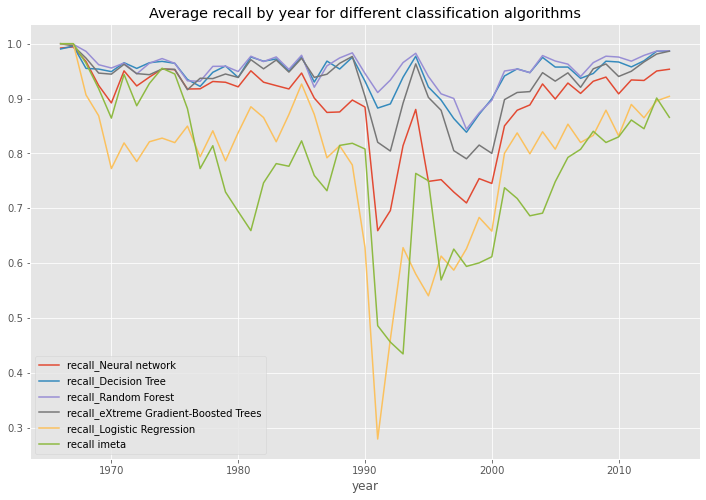

In [139]:
d1 = {
    f'recall_{classifier_opts[k1]["name"]}': 
    metrics_annual_cv_df[[f'recall_instr_{k1}_{ix1}' 
                          for ix1 in range(num_test_splits)]].mean(axis='columns') 
    for k1,v1 in clf_dict_cv.items()}
d1.update({
    'recall imeta': metrics_annual_cv_df['recall_instr_imeta'],
    'year': metrics_annual_cv_df['year'],
})
fig1 = matplotlib.pyplot.figure('recall_by_year_different_algorithms',figsize=)
ax1 = fig1.add_subplot(1,1,1,title='Average recall by year for different classification algorithms')
pandas.DataFrame(d1).plot.line(x='year', ax=ax1)
fig1.savefig(plots_dir / 'recall_by_year_classifier_comparison_test_data.png')

0.7598702001081665

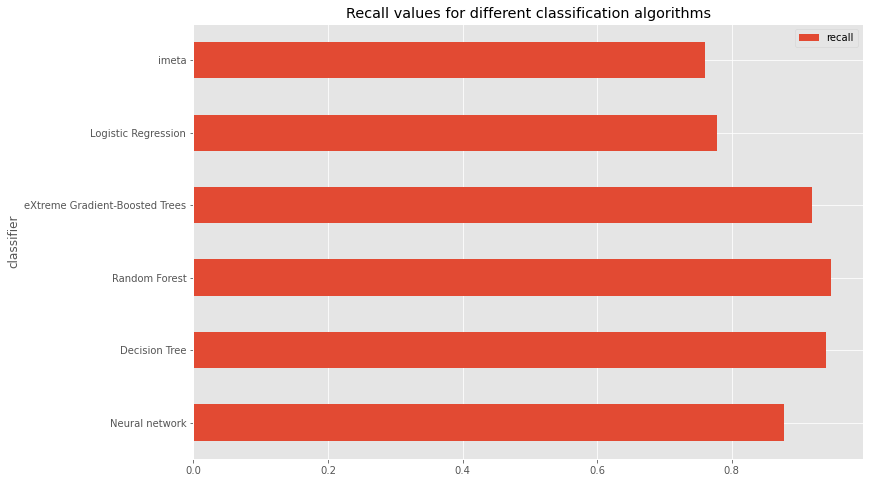

In [ ]:
d1 = {
    'recall': [metrics_all_classifiers[metrics_all_classifiers['classifier'].str.contains(clf_name) & metrics_all_classifiers['classifier'].str.contains('cv')]['recall_instr_ens'].mean() for clf_name in classifier_opts.keys()],
    'classifier': [f'{classifier_opts[clf_name]["name"]}' for clf_name in classifier_opts.keys()]
}
d1['recall'] += [metrics_imeta_all['recall_instr_ens']]
d1['classifier'] += ['imeta']
fig1 = matplotlib.pyplot.figure('recall_different_algorithms', figsize=(12,8))
ax1 = fig1.add_subplot(1,1,1, title='Recall values for different classification algorithms')
pandas.DataFrame(d1).plot.barh(x='classifier',ax=ax1)
fig1.savefig(plots_dir / 'average_recall_by_algorithm_test_data.png')

In [ ]:
fig1 = matplotlib.pyplot.figure('imbalanced_metrics_all', figsize=(12,28))
ax1 = fig1.add_subplot(3,1,1,title='Recall for all data in splits')
ΩΩ.plot.barh(x='classifier', y='recall_instr_ens', ax=ax1)
ax1 = fig1.add_subplot(3,1,2,title='Precision for all data in splits')
metrics_all_classifiers.plot.barh(x='classifier', y='precision_instr_ens', ax=ax1)
ax1 = fig1.add_subplot(3,1,3,title='F1 for all data in splits')
metrics_all_classifiers.plot.barh(x='classifier', y='f1_instr_ens', ax=ax1)

In [ ]:
metrics_per_class_cv_df_plot = metrics_per_class_cv_df[[(xbt_test.filter_obs({target_feature_name: ins1}).shape[0] >10) for ins1 in metrics_per_class_cv_df['instrument']]]
metrics_per_class_resampled_df_plot = metrics_per_class_resampled_df[[(xbt_test.filter_obs({target_feature_name: ins1}).shape[0] >10) for ins1 in metrics_per_class_resampled_df['instrument']]]

In [ ]:
metrics_per_class_cv_df[['recall_instr_avg', 'instrument', 'num_profiles']]

We see that results are comparable for the three tree based algorithms. We have chosen decision trees as a result as they are much quicker to train, and also easier to explain and interpret to the users of the system (ocean scientists), both for individual trees and our bespoke ensemble.